# Notifications - Time Series Forecasting
Built on a custom dataset based on 1 year of hourly notifications volume data (all platforms).

In [2]:
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.dataset import common
from gluonts.model import deepar

In [6]:
df = pd.read_csv('./src_data/hourly_notif_1yr.csv', header=0, index_col=0)

## 1Yr72Hr

In [7]:
# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': 1,
    'num_steps': 8657,
    'prediction_length': 72,
    'freq': '1H',
    'start': df.index[0]
}

In [9]:
# train dataset: cut the last window of length "prediction_length", "target" = [last record - pred length]
train_ds = common.ListDataset([{
    'start': df.index[0],
    'target': df.value[:'2019-07-07 17:00:00']}],
    freq='1H')

# test dataset: use the whole dataset, "target" field is last value, "start" field is first value
test_ds = common.ListDataset([{
    'start': df.index[0],
    'target': df.value[:'2019-07-07 17:00:00']}],
    freq='1H')

In [5]:
# Estimator is a modified RNN approach - Deep Autoregressive Recurrent Networks (DeepAR)
# Implementation based on:"DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks."(2017)
# https://github.com/awslabs/gluon-ts/blob/master/src/gluonts/model/deepar/_estimator.py

In [11]:
estimator = deepar.DeepAREstimator(freq='1H', prediction_length=72)
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:21<00:00,  2.36it/s, epoch=100/100, avg_epoch_loss=15.6]


In [12]:
prediction = next(predictor.predict(test_ds))
prediction.mean

array([ 9503628. ,  8710808. ,  8183451. ,  7306789. ,  5190721.5,
        5540297.5,  7312811.5,  7219656.5,  7431418. ,  8302263. ,
        9727749. , 11350547. , 13029248. , 14207923. , 13221674. ,
       17765712. , 17458728. , 18169156. , 18564802. , 15471398. ,
       13941124. , 13756250. , 12051168. , 12472995. , 10816334. ,
        9533910. ,  8457503. ,  6683883. ,  6113600.5,  7001961.5,
        8232773. ,  8999162. ,  8266688. ,  9023802. , 10169610. ,
       11133098. , 13400704. , 14423538. , 15271890. , 18557904. ,
       20570154. , 20153010. , 19020244. , 16711855. , 15661892. ,
       14036844. , 13478728. , 14066630. , 11017413. , 10489341. ,
        9117945. ,  7155439.5,  6549987. ,  6996679. ,  9162918. ,
        9256019. ,  8580626. ,  9013460. , 10254111. , 11778508. ,
       12991681. , 14921187. , 17042188. , 18380176. , 18685206. ,
       19903358. , 19574072. , 17381828. , 15293976. , 13988809. ,
       13256266. , 13703273. ], dtype=float32)

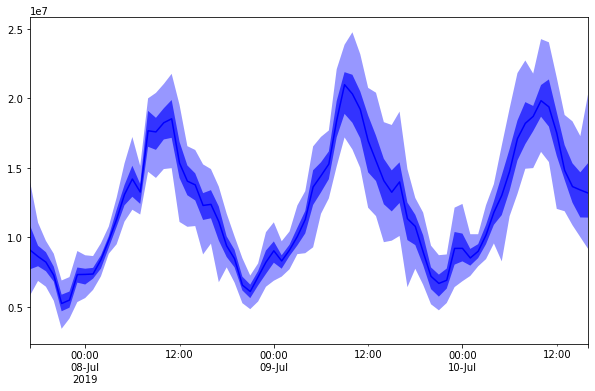

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
prediction.plot();

In [16]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [18]:
make_evaluation_predictions?

In [19]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,      # test dataset
    predictor=predictor,  # predictor
    num_samples=72,  # number of sample paths we want for evaluation
)

In [20]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [21]:
# first entry of the time series list
ts_entry = tss[0]

In [22]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([10054431., 16283725., 19080184., 12274166., 13031331.],
      dtype=float32)

In [23]:
# first entry of test_ds
test_ds_entry = next(iter(test_ds))

In [24]:
# first 5 values
test_ds_entry['target'][:5]

array([10054431., 16283725., 19080184., 12274166., 13031331.],
      dtype=float32)

In [25]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [26]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 72
Dimension of samples: (72, 72)
Start date of the forecast window: 2019-07-04 17:00:00
Frequency of the time series: 1H


In [27]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [12558187.  11293765.   9635065.   7069236.   6611543.   7398832.5
  8486855.   8666867.   8143284.5  9189096.  10498516.  11933845.
 12682765.  15042206.  17508492.  18949494.  20875312.  18398418.
 19414188.  16364096.  14172645.  12702028.  11604481.  11633960.
 11761820.  11108865.   9550520.   7380580.   6154588.5  7518009.
  7680409.   8429050.   8351282.   9240603.  10563308.  11215604.
 13529297.  16827836.  16625700.  18222118.  17315096.  16943654.
 15756549.  14719451.  12615810.  11548964.  11005070.  10228069.
 11049447.   9841098.   8674788.   7127634.   6345823.5  6344851.
  7187219.   8067327.   8640976.   8735641.   9795207.  10814015.
 11727239.  12682140.  14255442.  15992981.  17196962.  16800120.
 15943383.  14047929.  13173424.  10120544.  10256888.  10083287. ]
0.5-quantile (median) of the future window:
 [12175789.  11089512.   9744660.   7140375.5  6792031.5  7516796.5
  8449989.   8852102.   8201323.   9274326.  10678233.  11756289.

In [50]:
def plot_prob_forecasts(ts_entry, forecast_entry, plot_length, prediction_intervals=(50.0, 90.0)):

    legend = ["observations", "median prediction"] \
           + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(17, 11))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

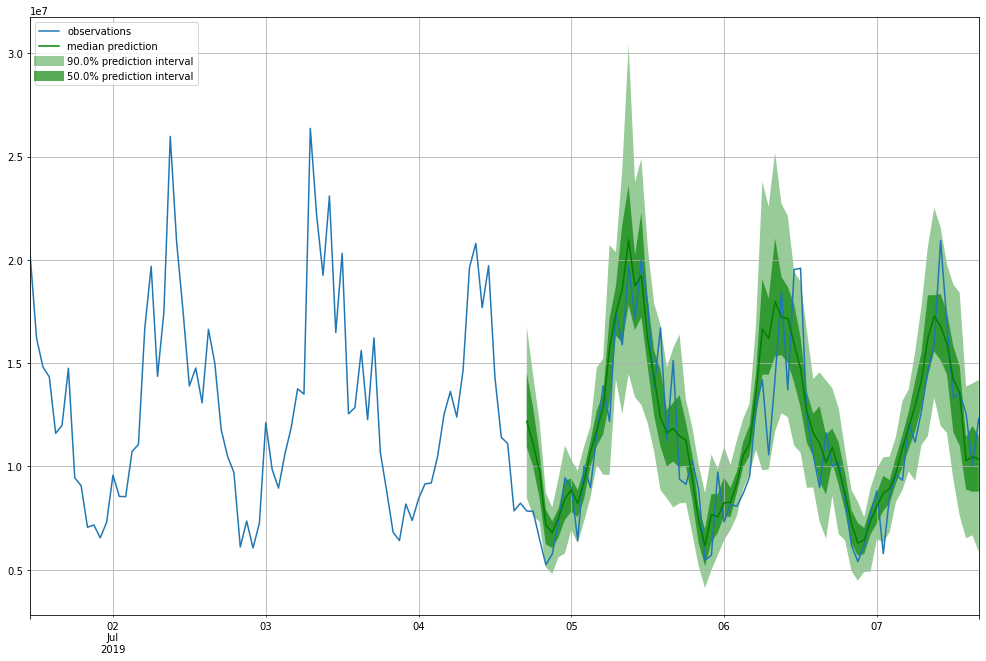

In [29]:
plot_prob_forecasts(ts_entry, forecast_entry, 150)

## Computing metrics

The `Evaluator` class in GluonTS can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [30]:
from gluonts.evaluation import Evaluator

In [31]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


In [32]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 4265501844366.222,
    "abs_error": 114912448.0,
    "abs_target_sum": 815841088.0,
    "abs_target_mean": 11331126.222222222,
    "seasonal_error": 2083212.8732624694,
    "MASE": 0.7661272847852344,
    "MAPE": 0.1526951922310723,
    "sMAPE": 0.14203098085191515,
    "MSIS": 4.1569814801361655,
    "QuantileLoss[0.1]": 46302110.800000004,
    "Coverage[0.1]": 0.125,
    "QuantileLoss[0.5]": 114912449.0,
    "Coverage[0.5]": 0.6527777777777778,
    "QuantileLoss[0.9]": 52034363.999999985,
    "Coverage[0.9]": 0.9166666666666666,
    "RMSE": 2065309.1401449377,
    "NRMSE": 0.18226865535170927,
    "ND": 0.14085150857221843,
    "wQuantileLoss[0.1]": 0.05675383537437134,
    "wQuantileLoss[0.5]": 0.1408515097979473,
    "wQuantileLoss[0.9]": 0.06378002378816203,
    "mean_absolute_QuantileLoss": 71082974.60000001,
    "mean_wQuantileLoss": 0.08712845632016024,
    "MAE_Coverage": 0.0648148148148148,
    "OWA": NaN
}


In [33]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,4.265502e+12,114912448.0,815841088.0,1.133113e+07,2.083213e+06,0.766127,0.152695,0.142031,4.156981,46302110.8,0.125,114912449.0,0.652778,52034364.0,0.916667


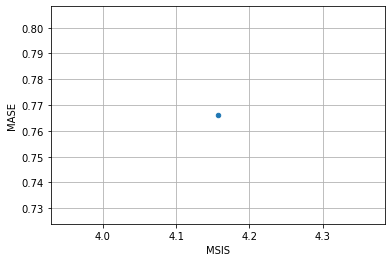

In [34]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter') # MSIS -- Mean Scaled Interval Score
plt.grid(which="both")
plt.show()

## 1Yr336Hr

Built on a custom dataset based on 6 months of hourly notifications volume data (all platforms).

In [35]:
custom_ds_metadata = {
    'num_series': 1,
    'num_steps': 8279,
    'prediction_length': 336,
    'freq': '1H',
    'start': df.index[0]
}

In [36]:
train_ds = common.ListDataset([{
    'start': df.index[0],
    'target': df.value[:'2019-07-03 17:00:00']}], 
    freq='1H')
test_ds = common.ListDataset([{
    'start': df.index[0],
    'target': df.value[:'2019-07-10 17:00:00']}],
    freq='1H')

In [37]:
estimator = deepar.DeepAREstimator(freq='1H', prediction_length=336)
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [01:17<00:00,  1.55s/it, epoch=98/100, avg_epoch_loss=15.5]


100%|██████████| 50/50 [01:29<00:00,  1.78s/it, epoch=100/100, avg_epoch_loss=15.6]


In [38]:
prediction = next(predictor.predict(test_ds))
prediction.mean

array([10790711. ,  9603945. ,  8655963. ,  7022192.5,  7104045. ,
        8294468. ,  9414919. ,  8634874. ,  8192171.5,  8779057. ,
       10255240. , 12113697. , 13244915. , 14814559. , 13561368. ,
       16253628. , 18592066. , 18524724. , 18345138. , 16183933. ,
       14209112. , 13561180. , 11972854. , 11346171. , 10763171. ,
        9552616. ,  9494991. ,  8299548. ,  7892098.5,  8513163. ,
        8891765. ,  8436049. ,  7646203.5,  8730760. , 10120703. ,
       11819721. , 13152252. , 14966660. , 14679210. , 16295630. ,
       17925234. , 17999770. , 17817564. , 16647958. , 14505116. ,
       12475457. , 13994779. , 12180507. , 12301413. , 11151900. ,
        9073754. ,  7256979. ,  6516017.5,  7459195.5,  9027250. ,
        7976864. ,  7922562.5,  8418730. ,  9722393. , 10564781. ,
       12857668. , 13771942. , 13612321. , 14806569. , 16209322. ,
       17297168. , 16509546. , 14923501. , 13451771. , 13531354. ,
       12308371. , 11444449. , 10601117. ,  9882179. ,  825698

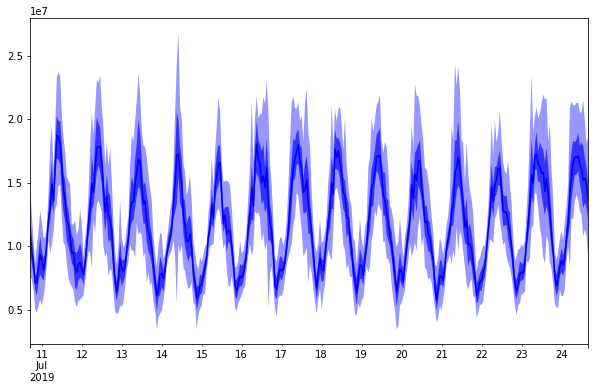

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
prediction.plot();

In [41]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,      # test dataset
    predictor=predictor,  # predictor
    num_samples=336,      # number of sample paths we want for evaluation
)

In [42]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [43]:
# first entry of the time series list
ts_entry = tss[0]

In [44]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([10054431., 16283725., 19080184., 12274166., 13031331.],
      dtype=float32)

In [45]:
# first entry of test_ds
test_ds_entry = next(iter(test_ds))

In [46]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [47]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 336
Dimension of samples: (336, 336)
Start date of the forecast window: 2019-06-26 17:00:00
Frequency of the time series: 1H


In [48]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [12345163.  10693874.   8714727.   7027680.   6345433.   7081713.
  8676674.   7933949.5  7795322.5  9189966.  10527288.  12100372.
 13659787.  17587014.  16085317.  17594546.  17537400.  19056462.
 19482218.  18066896.  16619468.  15766537.  13801586.  12183210.
 11846132.  10747861.   8926986.   7161457.   6049346.5  7091458.5
  8384086.   8019226.   7360167.5  8937753.  10380661.  11777247.
 12605379.  15218734.  16667983.  17928688.  17408094.  17330122.
 16802570.  15856509.  14924491.  13269379.  14032963.  12821461.
 11653287.  11565602.  10532066.   8094877.   6713726.5  7353140.
  8123725.5  7977263.   7229009.5  8764954.   9892074.  10838541.
 11879849.  12499728.  13637822.  15719444.  17430484.  15588450.
 15640259.  15298074.  14578776.  13425815.  12013234.  11362005.
 10857523.   9946434.   9823345.   8210091.5  6632722.5  6092104.
  6876333.   7176365.   6969869.5  8350933.5  9907269.  11105500.
 10793081.  12341915.  14888698.  15167538.  16

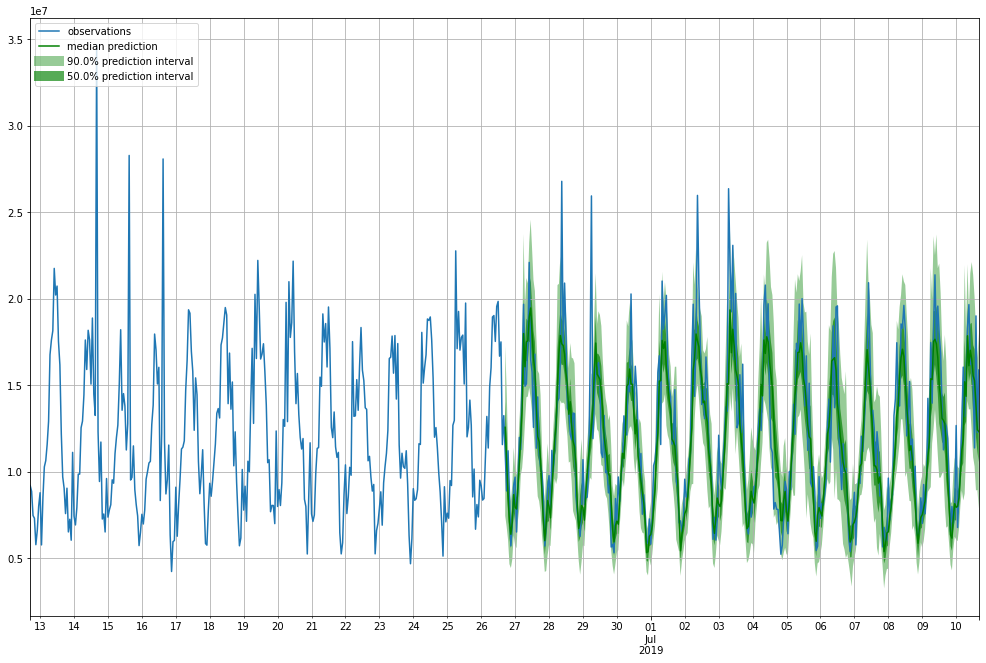

In [51]:
plot_prob_forecasts(ts_entry, forecast_entry, 672)

In [52]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


In [54]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 5057465399003.429,
    "abs_error": 545133504.0,
    "abs_target_sum": 4078558208.0,
    "abs_target_mean": 12138566.095238095,
    "seasonal_error": 2079277.2106583822,
    "MASE": 0.7802813085915656,
    "MAPE": 0.1285631770179385,
    "sMAPE": 0.13138539450509207,
    "MSIS": 5.980588846688981,
    "QuantileLoss[0.1]": 208585400.0,
    "Coverage[0.1]": 0.044642857142857144,
    "QuantileLoss[0.5]": 545133521.0,
    "Coverage[0.5]": 0.44047619047619047,
    "QuantileLoss[0.9]": 294999792.79999995,
    "Coverage[0.9]": 0.8571428571428571,
    "RMSE": 2248880.9214814883,
    "NRMSE": 0.1852674281160535,
    "ND": 0.13365838519375128,
    "wQuantileLoss[0.1]": 0.05114194510963812,
    "wQuantileLoss[0.5]": 0.1336583893618909,
    "wQuantileLoss[0.9]": 0.07232943058685898,
    "mean_absolute_QuantileLoss": 349572904.59999996,
    "mean_wQuantileLoss": 0.08570992168612934,
    "MAE_Coverage": 0.05257936507936511,
    "OWA": NaN
}


In [55]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,5.057465e+12,545133504.0,4.078558e+09,1.213857e+07,2.079277e+06,0.780281,0.128563,0.131385,5.980589,208585400.0,0.044643,545133521.0,0.440476,294999792.8,0.857143


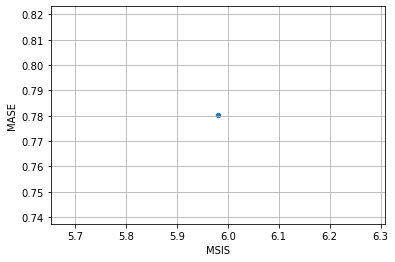

In [56]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both");

Built on a custom dataset based on 2 years of hourly notifications volume data (all platforms).

## 2Yr72Hr

In [58]:
df = pd.read_csv('./src_data/hourly_notif_2yr.csv', header=0, index_col=0)

In [59]:
df.head()

,value
timestamp,
2017-07-18 00:00:00,8602158
2017-07-18 01:00:00,8578067
2017-07-18 02:00:00,5515360
2017-07-18 03:00:00,6486492
2017-07-18 04:00:00,9706628


In [60]:
# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': 1,
    'num_steps': 17434,
    'prediction_length': 72,
    'freq': '1H',
    'start': df.index[0]
}

In [61]:
# train dataset: cut the last window of length "prediction_length", "target" = [last record - pred length]
train_ds = common.ListDataset([{
    'start': df.index[0],
    'target': df.value[:'2019-07-14 11:00:00']}], freq='1H')
# test dataset: use the whole dataset, "target" field is last value, "start" field is first value
test_ds = common.ListDataset([{
    'start': df.index[0],
    'target': df.value[:'2019-07-14 11:00:00']}], freq='1H')

In [62]:
estimator = deepar.DeepAREstimator(freq='1H', prediction_length=72)
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:22<00:00,  2.24it/s, epoch=98/100, avg_epoch_loss=15.8]


100%|██████████| 50/50 [00:20<00:00,  2.41it/s, epoch=100/100, avg_epoch_loss=15.8]


In [63]:
prediction = next(predictor.predict(test_ds))
prediction.mean

array([15622717. , 14827963. , 12711227. , 11115238. , 11401851. ,
       11189551. ,  9489539. ,  9162253. ,  8002163. ,  6531478. ,
        5183184. ,  5531677. ,  6394181. ,  7598560. ,  7110256.5,
        8365371.5,  9119960. , 11325495. , 13227194. , 14647366. ,
       14259657. , 16175075. , 17906262. , 17740914. , 17467768. ,
       16155082. , 13391114. , 13528859. , 13350511. , 11547414. ,
       11677289. ,  9691699. ,  8897197. ,  6687559.5,  5894818. ,
        6373021.5,  7341018. ,  8210199.5,  7985436. ,  9127462. ,
        9580493. , 11799583. , 13375642. , 15244113. , 14740588. ,
       17380152. , 19090800. , 19044058. , 18241430. , 16903496. ,
       15205372. , 13408746. , 13819534. , 12746811. , 11660081. ,
       10405619. ,  8853324. ,  6450532.5,  6005702. ,  6622323. ,
        7719243. ,  9202013. ,  8112878. ,  8981395. ,  9806585. ,
       11523900. , 13562030. , 15100128. , 15843621. , 17307220. ,
       17461456. , 18357246. ], dtype=float32)

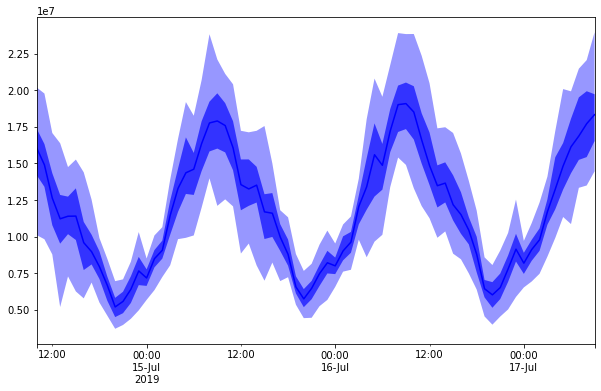

In [64]:
fig, ax = plt.subplots(figsize=(10,6))
prediction.plot();

In [65]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,      # test dataset
    predictor=predictor,  # predictor
    num_samples=72,       # number of sample paths we want for evaluation
)

In [66]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [67]:
# first entry of the time series list
ts_entry = tss[0]

In [71]:
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([8602158., 8578067., 5515360., 6486492., 9706628.], dtype=float32)

In [72]:
# first entry of test_ds
test_ds_entry = next(iter(test_ds))

In [73]:
# first 5 values
test_ds_entry['target'][:5]

array([8602158., 8578067., 5515360., 6486492., 9706628.], dtype=float32)

In [74]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [75]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 72
Dimension of samples: (72, 72)
Start date of the forecast window: 2019-07-11 10:00:00
Frequency of the time series: 1H


In [76]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [18158018.  15932836.  14818236.  13516533.  12573249.  12557399.
 11081316.   9953145.   8523157.   7079728.5  6528090.   7039568.
  8260649.   9697891.   7813704.   8570302.   9979685.  11567708.
 14186039.  14367572.  14851576.  16929188.  18295072.  18059892.
 18442322.  16619518.  14440412.  13897940.  11749454.  13117107.
 11668732.  10442929.   9384044.   7549979.5  6295454.   6879223.5
  8061554.5  8832841.   8003146.5  8114890.   9338146.  10726804.
 13580869.  14240189.  12843797.  15474398.  17059106.  16512580.
 16636052.  14689419.  13392633.  11967892.  12242049.  11957949.
 10479599.   9275169.   8458121.   7084160.   6272262.   6595666.5
  7355902.5  8409956.   7931693.5  7905504.   9281163.  10400905.
 11948952.  12872910.  13150429.  15059753.  16381728.  16686007. ]
0.5-quantile (median) of the future window:
 [18193158.  15671974.  15076192.  13576226.  12424073.  12409176.
 11171076.   9840774.   8661085.   7138401.   6448460.5  7049118.

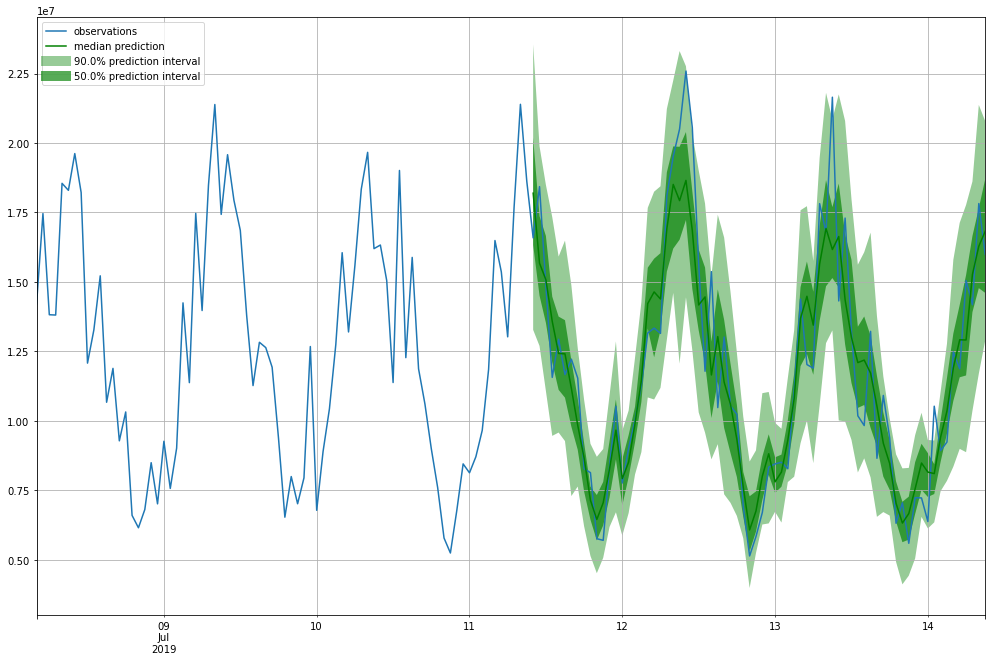

In [77]:
plot_prob_forecasts(ts_entry, forecast_entry, plot_length=150)

In [78]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


In [79]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 2695875847054.222,
    "abs_error": 97054768.0,
    "abs_target_sum": 849200320.0,
    "abs_target_mean": 11794448.888888888,
    "seasonal_error": 2189150.172799631,
    "MASE": 0.6157562444265752,
    "MAPE": 0.11515124638875325,
    "sMAPE": 0.11400736702813043,
    "MSIS": 4.00174282643963,
    "QuantileLoss[0.1]": 38398055.300000004,
    "Coverage[0.1]": 0.0,
    "QuantileLoss[0.5]": 97054775.0,
    "Coverage[0.5]": 0.5277777777777778,
    "QuantileLoss[0.9]": 45930589.09999999,
    "Coverage[0.9]": 0.9305555555555556,
    "RMSE": 1641912.2531530794,
    "NRMSE": 0.1392105954776627,
    "ND": 0.1142896036591225,
    "wQuantileLoss[0.1]": 0.04521672259850303,
    "wQuantileLoss[0.5]": 0.11428961190217168,
    "wQuantileLoss[0.9]": 0.05408687210574766,
    "mean_absolute_QuantileLoss": 60461139.800000004,
    "mean_wQuantileLoss": 0.07119773553547414,
    "MAE_Coverage": 0.052777777777777785,
    "OWA": NaN
}


In [80]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,2.695876e+12,97054768.0,849200320.0,1.179445e+07,2.189150e+06,0.615756,0.115151,0.114007,4.001743,38398055.3,0.0,97054775.0,0.527778,45930589.1,0.930556


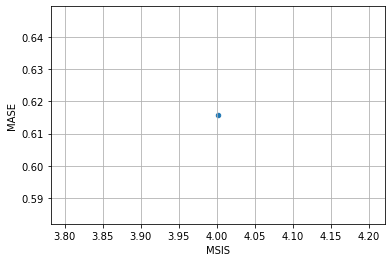

In [81]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

## 2Y168Hr

In [82]:
# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': 1,
    'num_steps': 17338,
    'prediction_length': 168,
    'freq': '1H',
    'start': df.index[0]
}

In [83]:
# train dataset: cut the last window of length "prediction_length", "target" = [last record - pred length]
train_ds = common.ListDataset([{
    'start': df.index[0],
    'target': df.value[:'2019-07-10 11:00:00']}], freq='1H')
# test dataset: use the whole dataset, "target" field is last value, "start" field is first value
test_ds = common.ListDataset([{
    'start': df.index[0],
    'target': df.value[:'2019-07-10 11:00:00']}], freq='1H')

In [84]:
estimator = deepar.DeepAREstimator(freq='1H', prediction_length=168)
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:43<00:00,  1.16it/s, epoch=98/100, avg_epoch_loss=15.7]


100%|██████████| 50/50 [00:40<00:00,  1.24it/s, epoch=100/100, avg_epoch_loss=15.7]


In [85]:
prediction = next(predictor.predict(test_ds))
prediction.mean

array([19419216. , 19213426. , 17403020. , 15381754. , 13972887. ,
       13684483. , 11146578. ,  9932916. ,  9582278. ,  7726482. ,
        7086338. ,  7851943.5,  8696669. ,  9062926. ,  8175332. ,
        8706538. , 10089841. , 12294839. , 14119141. , 15885494. ,
       15369859. , 17692826. , 18643952. , 19193220. , 18587184. ,
       17326028. , 15693432. , 13949239. , 12839603. , 12195706. ,
       11361414. , 10340729. ,  9003978. ,  7500510. ,  7109212. ,
        8241984. ,  8736422. ,  8986333. ,  7811290. ,  8924739. ,
        9781684. , 11807268. , 13318094. , 15005137. , 16266856. ,
       18253850. , 18654046. , 17824536. , 18329460. , 16506490. ,
       15508454. , 13682248. , 12955715. , 13876314. , 12851332. ,
       10499616. ,  9705044. ,  7978690. ,  7100271.5,  7510141.5,
        8580936. ,  9028558. ,  8671072. ,  8700262. ,  9514520. ,
       10706932. , 14058202. , 14262409. , 14075878. , 15214456. ,
       15984440. , 16388659. , 17072138. , 15735379. , 1313909

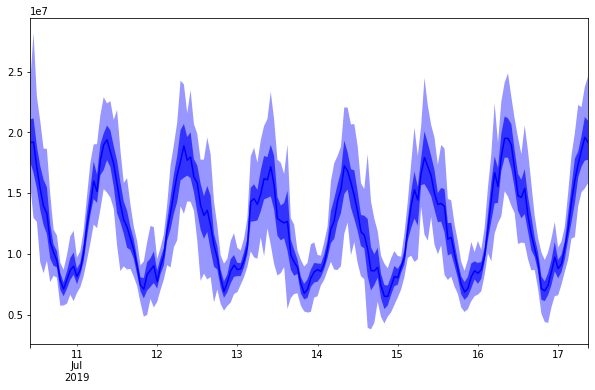

In [86]:
fig, ax = plt.subplots(figsize=(10,6))
prediction.plot();

In [87]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,       # test dataset
    predictor=predictor,   # predictor
    num_samples=168,       # number of sample paths we want for evaluation
)

In [88]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [89]:
# first entry of the time series list
ts_entry = tss[0]

In [90]:
# first 5 values of the time series (convert from pandas to numpy)
ts_entry[:5].to_numpy().reshape(-1,)

array([8602158., 8578067., 5515360., 6486492., 9706628.], dtype=float32)

In [91]:
# first entry of test_ds
test_ds_entry = next(iter(test_ds))

In [92]:
# first 5 values
test_ds_entry['target'][:5]

array([8602158., 8578067., 5515360., 6486492., 9706628.], dtype=float32)

In [93]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [94]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 168
Dimension of samples: (168, 168)
Start date of the forecast window: 2019-07-03 10:00:00
Frequency of the time series: 1H


In [95]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [18078886.  16082078.  15604975.  15728882.  14761108.  12700677.
 11099561.   9882380.   8986734.   7577280.   7243501.5  7298068.
  8582855.   9517006.   8763780.   9160153.  10642591.  11759851.
 14265073.  16419328.  17055592.  18905520.  18489108.  18981550.
 18186086.  16621876.  15304631.  14877350.  13649719.  11889107.
 11472740.  10158513.   9011826.   7366599.   7023351.5  7472909.
  8747843.   8764845.   8628677.   9254424.  10212345.  11229513.
 12861219.  15164108.  16525739.  18449138.  19135062.  19464866.
 19060124.  17257380.  16008117.  14511339.  13828145.  13782781.
 13031285.  11653160.   9659165.   7885287.5  6699831.5  7464619.5
  7853921.5  9112027.   8630629.   9075114.  10087807.  11243840.
 13892515.  15692626.  16879324.  16664713.  16594106.  16905538.
 16752282.  14549964.  12854043.  12964707.  12300874.  11351686.
 11326101.  10225048.   8994482.   7415874.5  6590477.   6705795.
  7294187.5  8381915.5  8624452.   8946910.  10

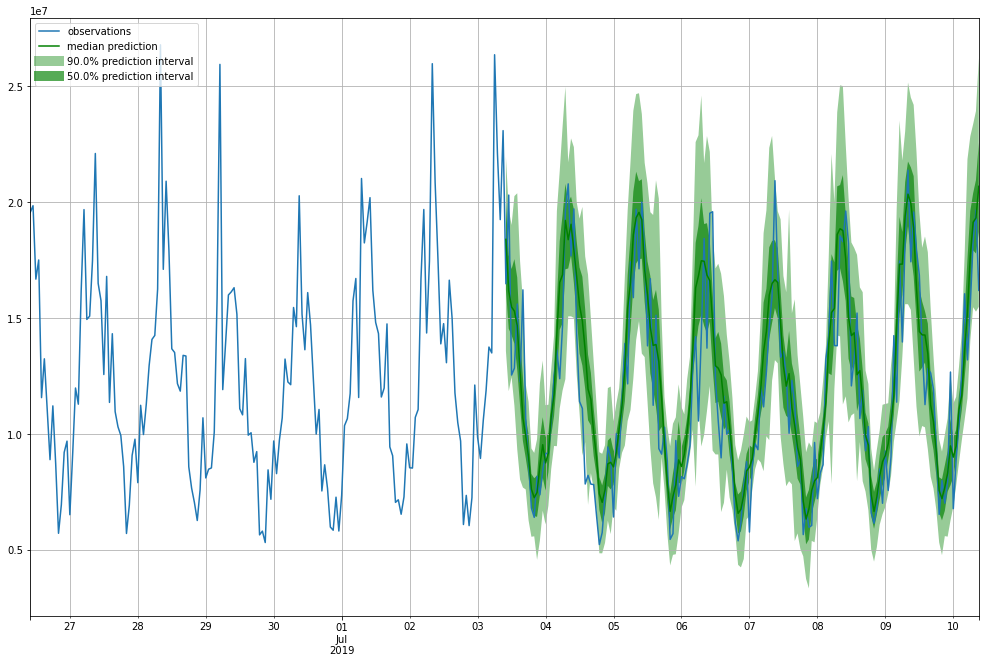

In [96]:
plot_prob_forecasts(ts_entry, forecast_entry, plot_length=336)

In [97]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


In [98]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 4075067526972.952,
    "abs_error": 267875392.0,
    "abs_target_sum": 1989964672.0,
    "abs_target_mean": 11845027.80952381,
    "seasonal_error": 2190839.698588592,
    "MASE": 0.7278014826824646,
    "MAPE": 0.1460272811707996,
    "sMAPE": 0.1354710261027018,
    "MSIS": 4.291876983171369,
    "QuantileLoss[0.1]": 105734524.6,
    "Coverage[0.1]": 0.1488095238095238,
    "QuantileLoss[0.5]": 267875387.0,
    "Coverage[0.5]": 0.6130952380952381,
    "QuantileLoss[0.9]": 127876827.99999997,
    "Coverage[0.9]": 0.9523809523809523,
    "RMSE": 2018679.6494176465,
    "NRMSE": 0.17042422203471388,
    "ND": 0.1346131395040163,
    "wQuantileLoss[0.1]": 0.05313387020772196,
    "wQuantileLoss[0.5]": 0.13461313699140887,
    "wQuantileLoss[0.9]": 0.06426085337056675,
    "mean_absolute_QuantileLoss": 167162246.53333333,
    "mean_wQuantileLoss": 0.0840026201898992,
    "MAE_Coverage": 0.07142857142857141,
    "OWA": NaN
}


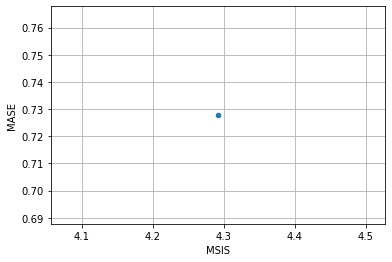

In [99]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

## 3Yr72Hr

In [101]:
df = pd.read_csv('./src_data/hourly_notif_3yr.csv', header=0, index_col=0)

In [102]:
# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': 1,
    'num_steps': 26174,
    'prediction_length': 72,
    'freq': '1H',
    'start': df.index[0]
}

In [103]:
# train dataset: cut the last window of length "prediction_length", "target" = [last record - pred length]
train_ds = common.ListDataset([{
    'start': df.index[0],
    'target': df.value[:'2019-07-14 17:00:00']}], freq='1H')
# test dataset: use the whole dataset, "target" field is last value, "start" field is first value
test_ds = common.ListDataset([{
    'start': df.index[0],
    'target': df.value[:'2019-07-14 17:00:00']}], freq='1H')

In [104]:
estimator = deepar.DeepAREstimator(freq='1H', prediction_length=72)
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:20<00:00,  2.43it/s, epoch=98/100, avg_epoch_loss=15.6]


100%|██████████| 50/50 [00:22<00:00,  2.18it/s, epoch=100/100, avg_epoch_loss=15.6]


In [105]:
prediction = next(predictor.predict(test_ds))
prediction.mean

array([ 9614726. ,  9215187. ,  8684801. ,  6872799.5,  5764058. ,
        5444217. ,  5896740. ,  7522057.5,  7423646.5,  8139860. ,
        8893081. , 11089430. , 13154989. , 13780236. , 14067145. ,
       15803264. , 17536004. , 17365770. , 17125506. , 15781992. ,
       13903264. , 12778209. , 12396298. , 11303599. , 11005249. ,
       10004063. ,  9090260. ,  7035977. ,  6288187.5,  6344256.5,
        7196935. ,  8185054. ,  7951817. ,  8825805. ,  9730951. ,
       11863283. , 13689559. , 14910001. , 15066536. , 17065276. ,
       18610858. , 18360514. , 17870516. , 16655110. , 15120724. ,
       13400056. , 13272881. , 12385905. , 11159205. , 10160380. ,
        9215188. ,  7339358. ,  6418833.5,  6299675. ,  7430530.5,
        9267482. ,  8017697.5,  9092387. ,  9925802. , 11411452. ,
       13946760. , 14748530. , 15799176. , 17737862. , 18163692. ,
       17451942. , 17073528. , 16014152. , 14106170. , 13678410. ,
       12357091. , 11857274. ], dtype=float32)

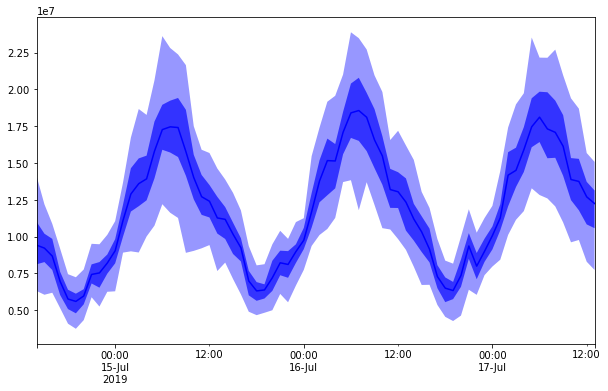

In [106]:
fig, ax = plt.subplots(figsize=(10,6))
prediction.plot();

In [107]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,      # test dataset
    predictor=predictor,  # predictor
    num_samples=72,       # number of sample paths we want for evaluation
)

In [108]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [109]:
# first entry of the time series list
ts_entry = tss[0]

In [110]:
# first 5 values of the time series (convert from pandas to numpy)
ts_entry[:5].to_numpy().reshape(-1,)

array([1448217., 1909150., 1886090., 2411731., 2764000.], dtype=float32)

In [111]:
# first entry of test_ds
test_ds_entry = next(iter(test_ds))

In [112]:
# first 5 values
test_ds_entry['target'][:5]

array([1448217., 1909150., 1886090., 2411731., 2764000.], dtype=float32)

In [113]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [114]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 72
Dimension of samples: (72, 72)
Start date of the forecast window: 2019-07-11 14:00:00
Frequency of the time series: 1H


In [115]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [10718128.   9622951.   8751932.   7203425.   6518418.   6773280.5
  8014599.   9403932.   7917970.5  8749371.   9860548.  11564275.
 13538572.  14794963.  15066972.  16582155.  18769152.  17072944.
 17776472.  16339703.  14132924.  12815409.  11720419.  13029611.
 11964811.   9908532.   9097428.   7093630.5  6227386.   6211698.
  7560709.5  8697900.   7884202.   8176090.   8932640.  10700848.
 12980876.  14180325.  13242858.  15249040.  15543692.  15858994.
 16494388.  14959831.  13076842.  11687246.  11782860.  10898768.
  9687212.   9113818.   8204057.   6801094.   6015899.5  6170550.
  7231621.   8269067.5  7778177.   7849993.   8824806.  10406786.
 12243178.  12441038.  13067268.  14417893.  15631577.  16016640.
 15029264.  14211791.  12216472.  11306861.  11305647.  11044899. ]
0.5-quantile (median) of the future window:
 [10741182.   9692038.   8647260.   7198890.   6518236.   6748783.
  8205251.5  9415415.   7894739.   8798905.   9876545.  11617450.


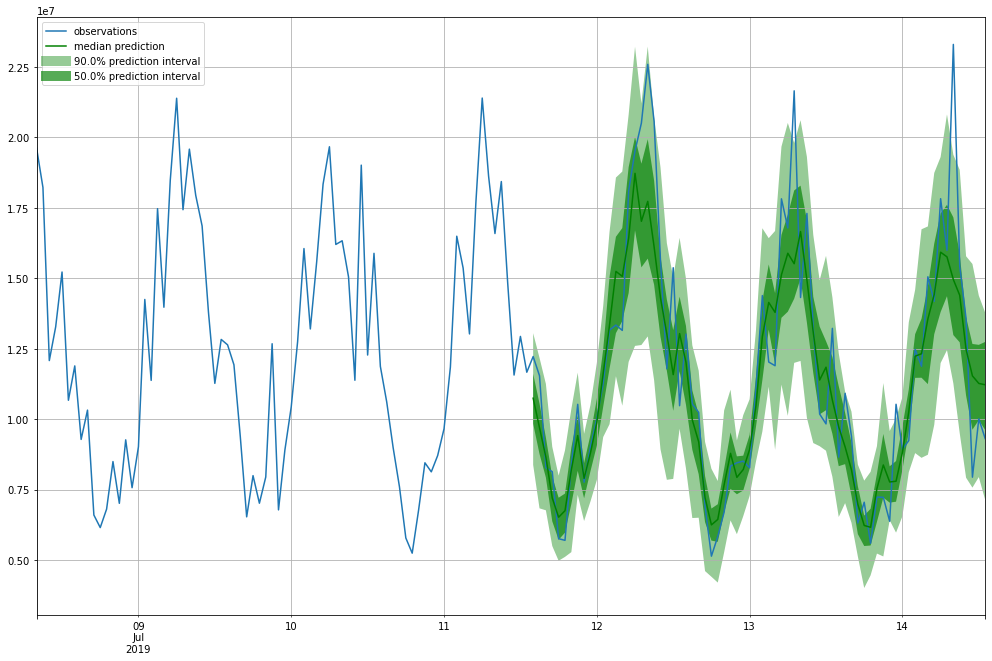

In [116]:
plot_prob_forecasts(ts_entry, forecast_entry, plot_length=150)

In [117]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


In [118]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 4007181185479.1113,
    "abs_error": 105429472.0,
    "abs_target_sum": 842749184.0,
    "abs_target_mean": 11704849.777777778,
    "seasonal_error": 1833267.223560089,
    "MASE": 0.7987369235667934,
    "MAPE": 0.11947699387868245,
    "sMAPE": 0.1205088562435574,
    "MSIS": 5.137843451817581,
    "QuantileLoss[0.1]": 42838740.85000001,
    "Coverage[0.1]": 0.027777777777777776,
    "QuantileLoss[0.5]": 105429471.5,
    "Coverage[0.5]": 0.4583333333333333,
    "QuantileLoss[0.9]": 50982569.89999999,
    "Coverage[0.9]": 0.8888888888888888,
    "RMSE": 2001794.4913200035,
    "NRMSE": 0.17102265550819004,
    "ND": 0.12510183812886375,
    "wQuantileLoss[0.1]": 0.05083213566184836,
    "wQuantileLoss[0.5]": 0.1251018375355674,
    "wQuantileLoss[0.9]": 0.060495543475957834,
    "mean_absolute_QuantileLoss": 66416927.416666664,
    "mean_wQuantileLoss": 0.07880983889112453,
    "MAE_Coverage": 0.041666666666666706,
    "OWA": NaN
}


In [119]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,4.007181e+12,105429472.0,842749184.0,1.170485e+07,1.833267e+06,0.798737,0.119477,0.120509,5.137843,42838740.85,0.027778,105429471.5,0.458333,50982569.9,0.888889


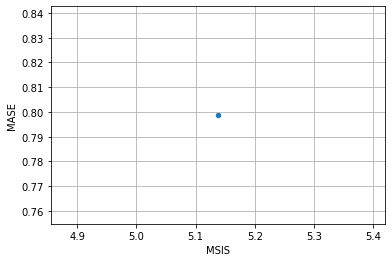

In [120]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which='both')
plt.show()

## 3Yr168Hr

In [121]:
# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': 1,
    'num_steps': 26078,
    'prediction_length': 168,
    'freq': '1H',
    'start': df.index[0]
}

In [122]:
# train dataset: cut the last window of length "prediction_length", "target" = [last record - pred length]
train_ds = common.ListDataset([{
    'start': df.index[0],
    'target': df.value[:'2019-07-07 17:00:00']}], freq='1H')
# test dataset: use the whole dataset, "target" field is last value, "start" field is first value
test_ds = common.ListDataset([{
    'start': df.index[0],
    'target': df.value[:'2019-07-14 17:00:00']}], freq='1H')

In [123]:
estimator = deepar.DeepAREstimator(freq='1H', prediction_length=72)
predictor = estimator.train(training_data=train_ds)

100%|██████████| 50/50 [00:17<00:00,  2.86it/s, epoch=98/100, avg_epoch_loss=15.6]


Early stopping based on learning rate scheduler callback (min_lr was reached).


In [124]:
prediction = next(predictor.predict(test_ds))
prediction.mean

array([ 9858404. ,  9328452. ,  8704361. ,  6685289. ,  5888441. ,
        5518168.5,  6621444. ,  7824961.5,  7065625.5,  8247985.5,
        8928352. , 11266735. , 13216337. , 13969192. , 14287526. ,
       16364404. , 17997894. , 18350852. , 18386082. , 17040944. ,
       14167308. , 12772836. , 12601247. , 11501588. , 11201937. ,
       10389213. ,  9178082. ,  7209014. ,  6086471.5,  6184430. ,
        7464160.5,  8448475. ,  7722307. ,  8697737. ,  9867697. ,
       11531089. , 14118536. , 15536915. , 15169108. , 17445860. ,
       18589164. , 18607680. , 17457240. , 16395712. , 14275229. ,
       12711287. , 13186254. , 12331114. , 11552737. , 10321566. ,
        9176550. ,  6804196.5,  6308661. ,  6310782. ,  7525243. ,
        9217809. ,  7958770. ,  8847422. , 10075121. , 11700957. ,
       13581156. , 15154351. , 16275666. , 17862728. , 18915572. ,
       17786640. , 18029770. , 16193302. , 13816673. , 13291354. ,
       13017340. , 13029044. ], dtype=float32)

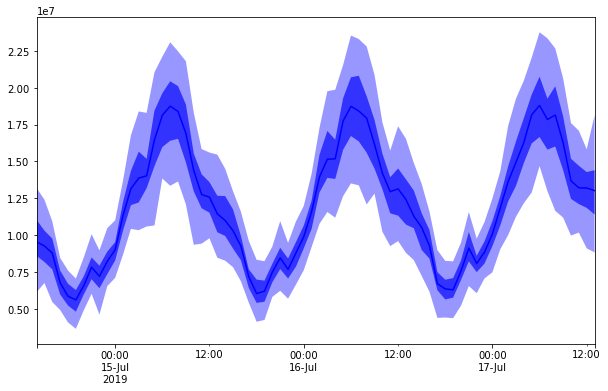

In [125]:
fig, ax = plt.subplots(figsize=(10,6))
prediction.plot();

In [126]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,      # test dataset
    predictor=predictor,  # predictor
    num_samples=168,      # number of sample paths we want for evaluation
)

In [127]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [128]:
# first entry of the time series list
ts_entry = tss[0]

In [129]:
# first 5 values of the time series (convert from pandas to numpy)
ts_entry[:5].to_numpy().reshape(-1,)

array([1448217., 1909150., 1886090., 2411731., 2764000.], dtype=float32)

In [130]:
# first entry of test_ds
test_ds_entry = next(iter(test_ds))

In [131]:
# first 5 values
test_ds_entry['target'][:5]

array([1448217., 1909150., 1886090., 2411731., 2764000.], dtype=float32)

In [132]:
# first entry of the forecast list
forecast_entry = forecasts[0]

In [133]:
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 168
Dimension of samples: (168, 72)
Start date of the forecast window: 2019-07-11 14:00:00
Frequency of the time series: 1H


In [134]:
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [10823849.   9815484.   8808962.   7074010.   6569825.5  6855273.
  8266522.5  9248851.   7903686.   8814338.   9947882.  11896052.
 13839238.  15088939.  14707200.  17133126.  18885632.  17616820.
 17981366.  16441384.  14360075.  13800197.  12064904.  13360262.
 11885586.  10004267.   9193362.   7047361.   6526668.   6522365.
  7886522.   8913068.   7912888.5  8351743.   9254909.  11130780.
 13319057.  14659832.  13538944.  15296043.  16804284.  15997277.
 16210563.  14925676.  12898310.  12276848.  11757799.  11112729.
 10278223.   9339042.   8373633.   6854813.   6269801.   6198822.
  7437666.5  8292791.   7585331.   8125198.5  9215880.  10786257.
 12393965.  12949335.  13395963.  14788812.  15695261.  15992332.
 15237534.  13946647.  12631958.  11569290.  10916491.  11322098. ]
0.5-quantile (median) of the future window:
 [10807896.   9715077.   8883639.   7157812.   6668770.   6789007.
  8131344.5  9252879.   8014767.   8856452.  10016352.  11883161.
 

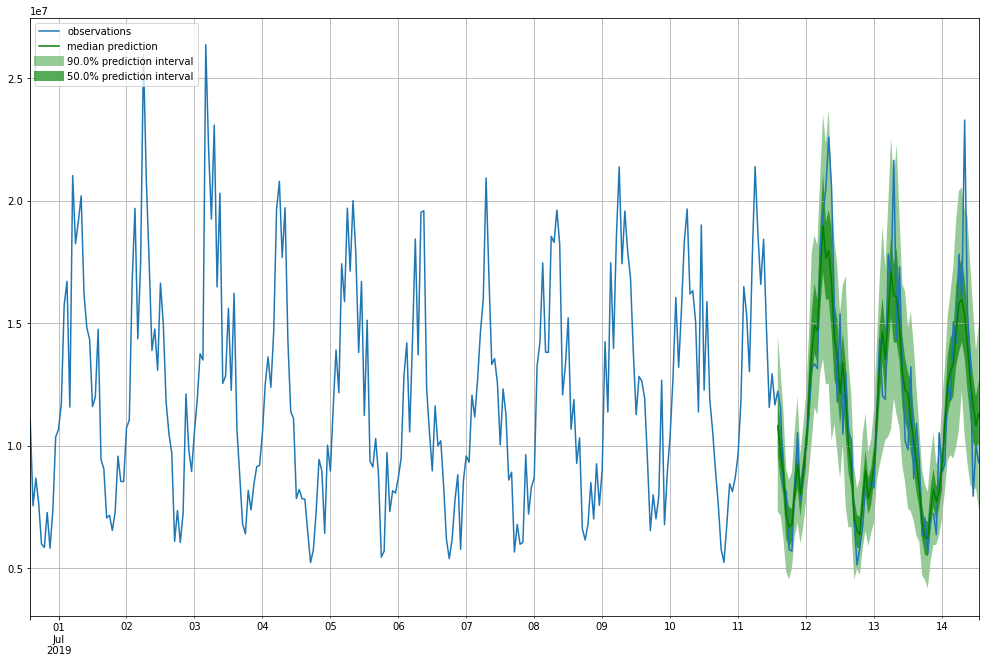

In [135]:
plot_prob_forecasts(ts_entry, forecast_entry, plot_length=336)

In [136]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


In [137]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 3905751729948.4443,
    "abs_error": 103881880.0,
    "abs_target_sum": 842749184.0,
    "abs_target_mean": 11704849.777777778,
    "seasonal_error": 1833267.223560089,
    "MASE": 0.7870123189608196,
    "MAPE": 0.12123678790198432,
    "sMAPE": 0.12037412325541179,
    "MSIS": 5.466120986434572,
    "QuantileLoss[0.1]": 40693346.3,
    "Coverage[0.1]": 0.041666666666666664,
    "QuantileLoss[0.5]": 103881881.0,
    "Coverage[0.5]": 0.5,
    "QuantileLoss[0.9]": 51725083.19999999,
    "Coverage[0.9]": 0.9166666666666666,
    "RMSE": 1976297.480125005,
    "NRMSE": 0.16884432672319308,
    "ND": 0.12326547681356165,
    "wQuantileLoss[0.1]": 0.048286426225717945,
    "wQuantileLoss[0.5]": 0.12326547800015432,
    "wQuantileLoss[0.9]": 0.06137660431125376,
    "mean_absolute_QuantileLoss": 65433436.833333336,
    "mean_wQuantileLoss": 0.07764283617904201,
    "MAE_Coverage": 0.024999999999999984,
    "OWA": NaN
}


In [138]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,3.905752e+12,103881880.0,842749184.0,1.170485e+07,1.833267e+06,0.787012,0.121237,0.120374,5.466121,40693346.3,0.041667,103881881.0,0.5,51725083.2,0.916667


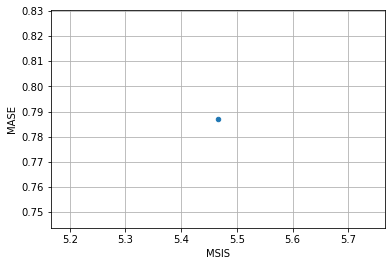

In [139]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which='both')
plt.show()